This file extract the data from an experiment folder and create a file with the obtained information

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import glob
import pickle as pkl

#modify some matplotlib parameters to manage the images for illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from skimage.filters import gaussian
import skimage.feature as skfeat
from scipy import ndimage

### Load Images

In [2]:
## Fill this two variables accord the files of interest
im_extension = 'tif'
nested_folder = 'test_images/Experimento-503-Profundidad de enfoque extendida-04/'

In [17]:
fpath = os.path.abspath(nested_folder)

im_names, fnames = file_names(fpath,im_extension)

D:\Github\Colony_correlations\codes\test_images\Experimento-503-Profundidad de enfoque extendida-04

folder "Experimento-503-Profundidad de enfoque extendida-04" = 4 files

file names:
['Experimento-503-Profundidad de enfoque extendida-04.tif', 'Experimento-503-Profundidad de enfoque extendida-04_Bright.tif', 'Experimento-503-Profundidad de enfoque extendida-04_DAPI.tif', 'Experimento-503-Profundidad de enfoque extendida-04_DiI.tif']


In [19]:
#Assign files to each cathegory - Fill only the numbers!
Im_ID = {}
Im_ID['dapi'] = fnames[2]
Im_ID['dii'] = fnames[3]
#Im_ID['dio'] = fnames[4]
Im_ID['bf'] = fnames[1]

# At the moment I'm not using it in anything

#### Get image data

Next box load and organize the image data of the images in the folder

In [21]:
im_data={}
im_data['R'],im_data['G'],im_data['B'],im_data['NormSum'] = get_im_data(fnames)
im_data['name']=fnames     # to store the related image source
# also define a vector with the channels
CHANNELS=['R','G','B']

Use next box to explore the channel values of a selected image

()

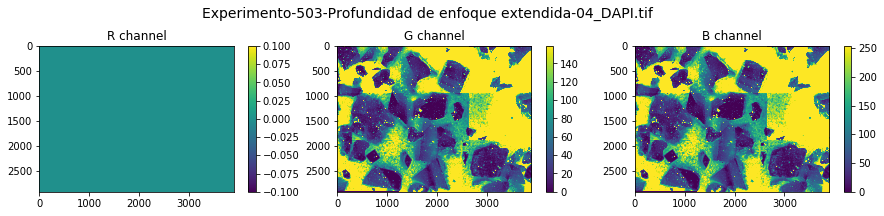

In [23]:
im_num = 2
plot_channels(im_data, im_num)

#### Detect bacterial colonies on each of them

In [24]:
#initialize the dictionaries to store the data
sImS = {}
sImSall = {}
detected={}
filter_sigma = {}
threshold = {}
sigma_lim = {}

 #### Execute next boxes to perform the analysis over each image
 (repeat this section for each of them)

Next box smooth the image and display some information to be able to determine the smoothing parameter "Filter_Sigma". A high filter sigma value means a stronger smoothing.

working on "Experimento-503-Profundidad de enfoque extendida-04_DiI.tif"


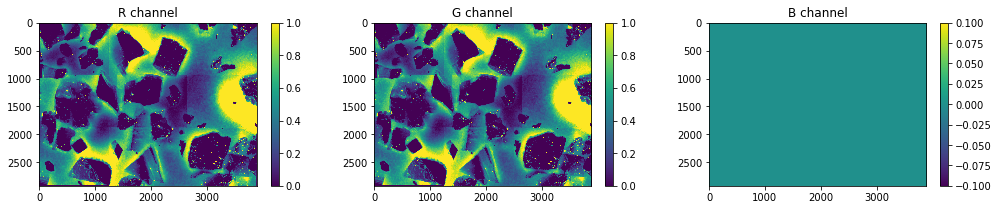

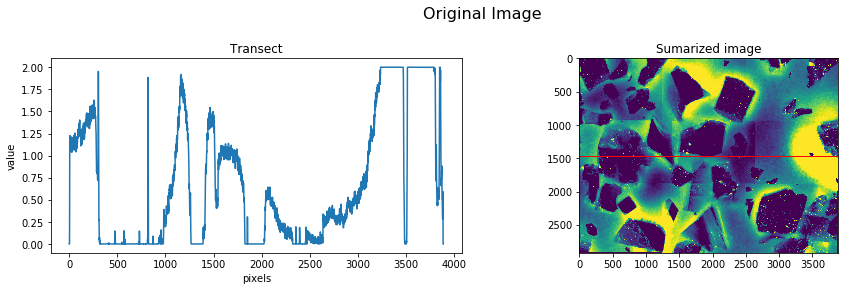

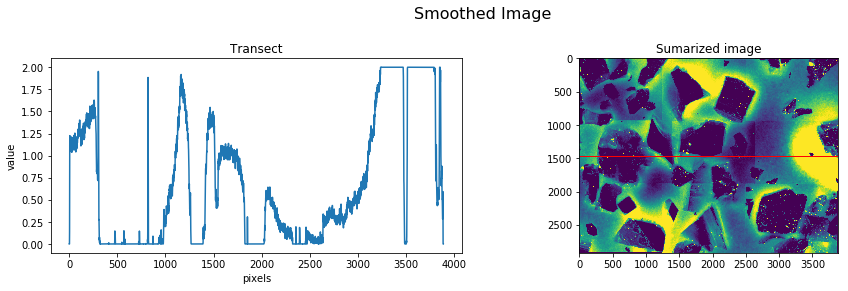

In [43]:
#Fill this two variables to set the filter properties
im_num = 3
filter_sigma[im_num] = 0.5

print('working on "' + im_data['name'][im_num].split("\\")[-1]+ '"')

#### apply the filter
sImS[im_num],sImSall[im_num] = smooth_data(im_data,filter_sigma[im_num],im_num)

##### Parameters definition and colony identification

To detect the colonies is necesary to define two parameters: **"sigma value"** (related to colony size) and **"Threhold value"** (related to what is considered a signficant level of signal) 

To be able to **estimate the expected colony radius** you can explore the image by running the next box:

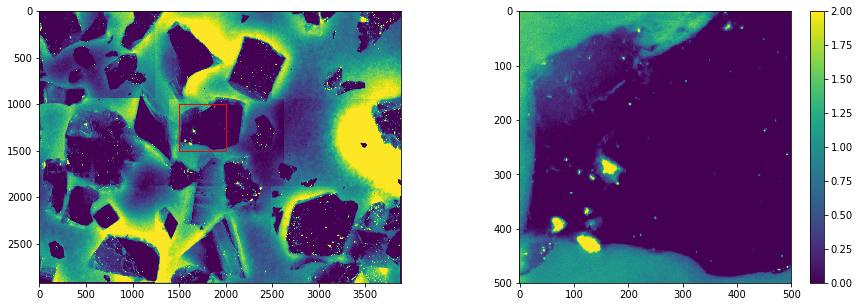

In [142]:
# perform a Zoom by slicing the image:

# modify next values accord the section you want to see:

x_lims = [1000,1500]    
y_lims = [1500,2000]    

########################
# Just make the plot ###
########################
im_zoom(x_lims, y_lims, sImSall[im_num])

In [147]:
# assign the stimated radius value in pixel units

Rmin = 2   # --> this should be estimated based on microscope resolution and bacterial size
Rmax = 35

#perform the sigma limits computation:
sigma_lim[im_num] = [Rmin/(2**0.5),Rmax/(2**0.5)]
print('sigma limits are: ' + str(sigma_lim[im_num]))

sigma limits are: [1.414213562373095, 24.74873734152916]


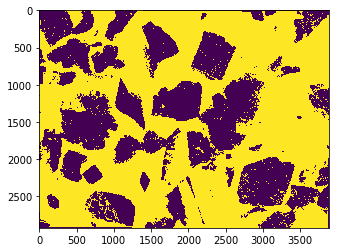

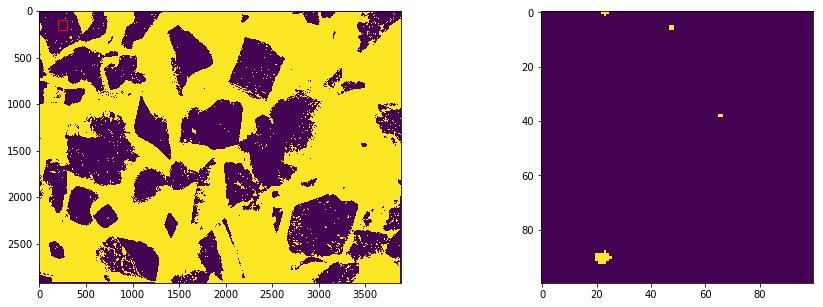

In [46]:
#define a Threshold
threshold[im_num]=0.35

##########################
## evaluate it visually ##
##########################

# whole image
thr_im = sImSall[im_num]>threshold[im_num]
plt.imshow(thr_im)

# zoom
x_lims = [100,200]    
y_lims = [200,300]    
im_zoom(x_lims, y_lims, thr_im, colorbar = False)

found 3245 colonies


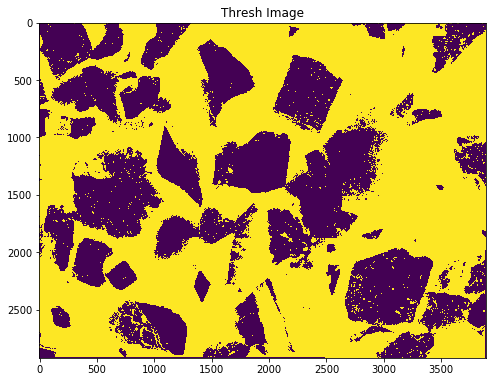

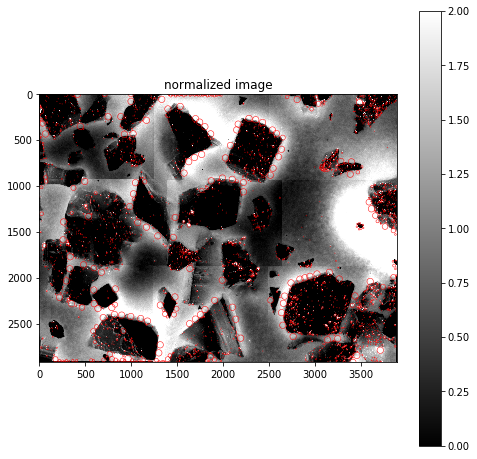

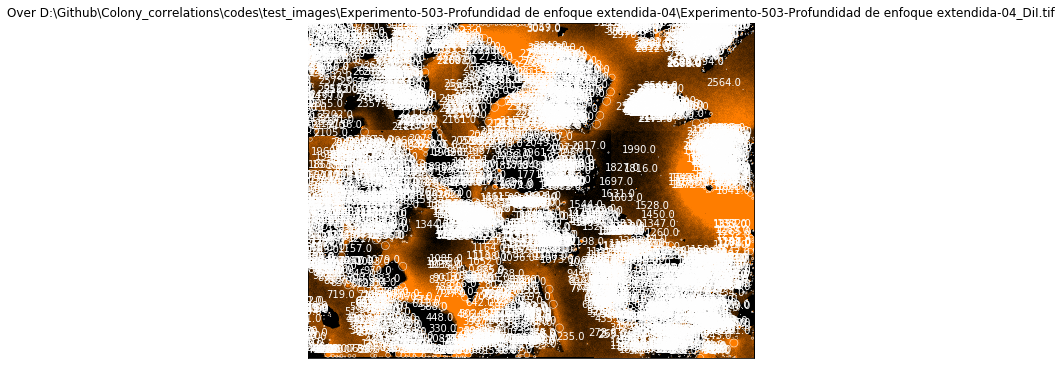

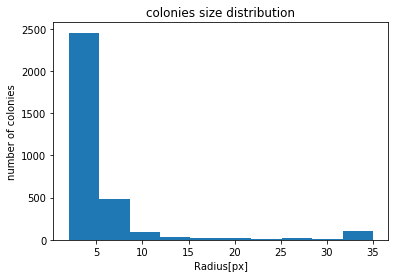

In [151]:
## Fill this two parameters only if you want to use a smaller region of the image (it's useful to verify the correct parameter choise)
x_lim = [0,-1]
y_lim = [0,-1]

#########################
### detect the images ###
#########################

detected[im_num]=colony_blobs_id(sImSall[im_num], threshold[im_num], fnames[im_num], sigma_lim[im_num])#, xlim=x_lim, ylim=y_lim) 

Whith the next box, you are able to perform a zoom over the image to check the detected colonies quality

()

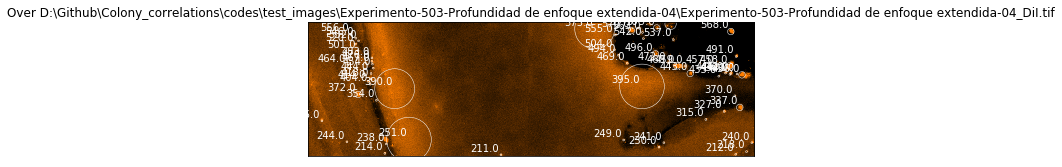

In [48]:
y_zoom = [2500,2800]
x_zoom = [2000,3000]
colony_plot(detected[im_num], fnames[im_num], y_zoom, x_zoom)

### BrightField filter

#### Smooth the image

working on "Experimento-503-Profundidad de enfoque extendida-04_Bright.tif"


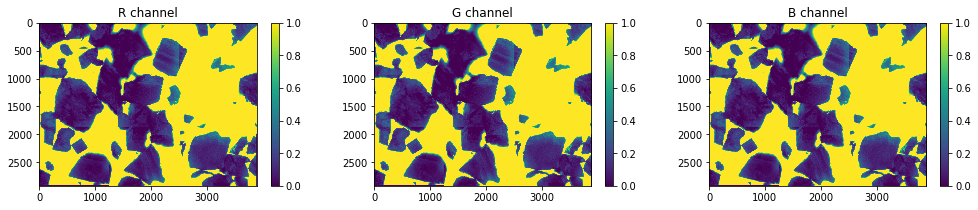

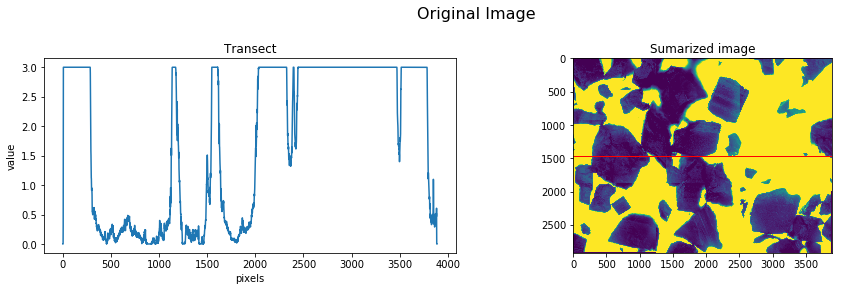

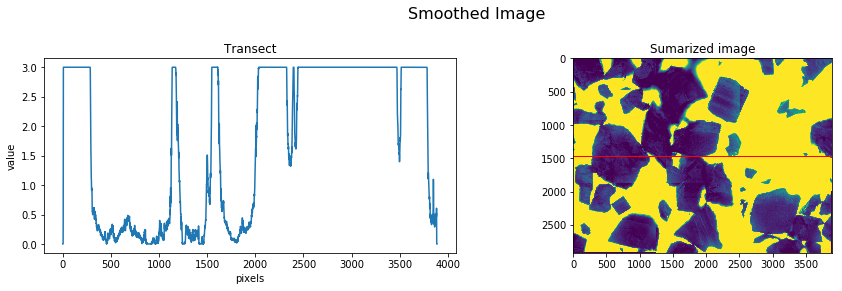

In [49]:
# fill this variable with desired filter parameter value:

filter_sigma[im_num] = 0.5

# image number correspont to the brighfield
im_num = im_data['name'].index(Im_ID['bf'])
print('working on "' + im_data['name'][im_num].split("\\")[-1]+ '"')

# Apply the filter
sImS[im_num],sImSall[im_num] = smooth_data(im_data,filter_sigma[im_num],im_num)

#### Determine the grain area

In [50]:
bf_cols = {}

Grain area is: 5492634 pixels
image percent 0.4835163461510529


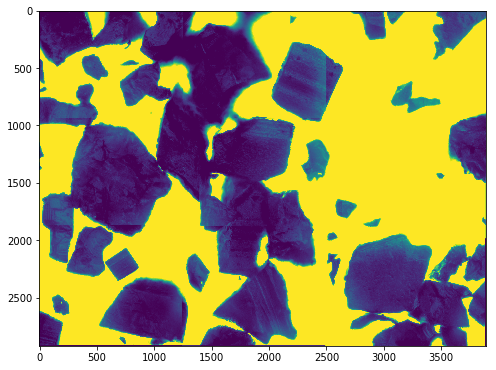

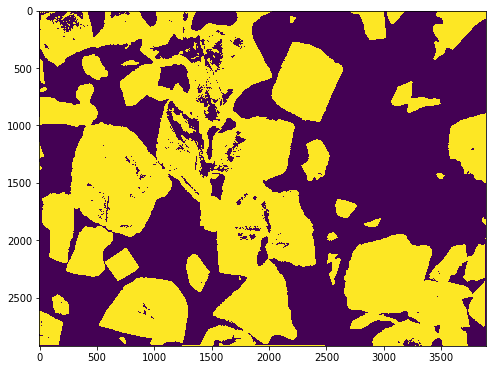

In [56]:
thresh_up = 2.5     # grain threshold
thresh_low = 0    # border threshold

bf_cols["bf_threshold"] = [thresh_up, thresh_low]  # save the used values
bin_bf, grain_area = binary_image(sImSall[im_num], thresh_up, thresh_low)

print("image percent " + str(grain_area/bin_bf.size))

####  Filter the colonies outside the grains
execute the next box for any image desired to consider only the colonies inside the grains (It is recomended to run it for both - DAPI and DII - images)

In [60]:
image = 'dii'   # write "dapi" or "dii"

###################################################################
im_num = im_data['name'].index(Im_ID[image])
print('working on "' + im_data['name'][im_num].split("\\")[-1]+ '"')

bf_cols[im_num] =  np.asarray(Bfield_filter(detected[im_num], bin_bf))

working on "Experimento-503-Profundidad de enfoque extendida-04_DiI.tif"


Next two boxes couls be used to compare the situtation with or without the colonies outside the grains

grain filtered colonies


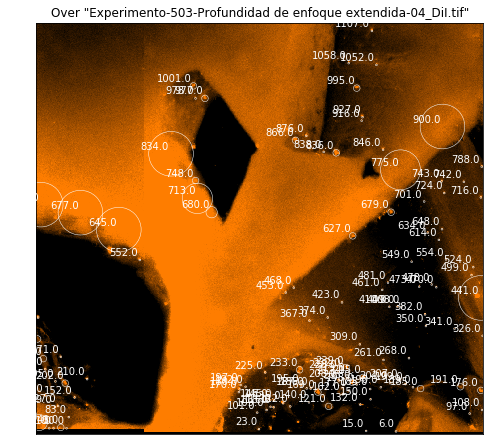

In [165]:
y_zoom = [2000,3000]
x_zoom = [1000,2000]
colony_plot(bf_cols[im_num], fnames[im_num], ylim = y_zoom, xlim = x_zoom)
print('grain filtered colonies')

previous grain filter


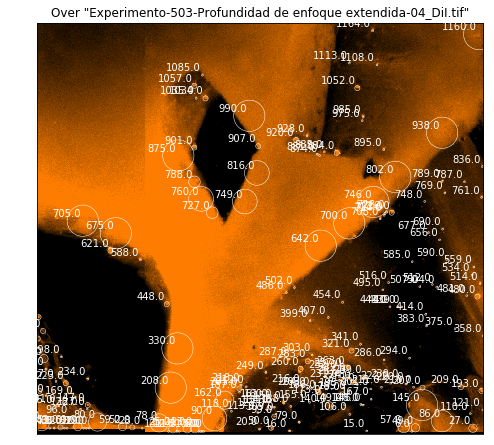

In [164]:
colony_plot(detected[im_num], fnames[im_num], ylim = y_zoom, xlim = x_zoom)

print('previous grain filter')

### Export data to CSV

In [108]:
import csv
im_clases = ['dapi','dii']        # They have to be in Im_ID.keys()
Headers = ['Dye', 'Y', 'X', 'Sigma' , 'Radii', 'ID']   # Y to ID are in "detected"

exp_name = fpath.split('\\')[-1]   # experiment name to be create the file

with open(exp_name+'.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(Headers)
    
    for image in im_clases:
        im_num = im_data['name'].index(Im_ID[image])
        
        for colony in bf_cols[im_num]:
            new_line = [image]
            for value in colony:
                new_line.append(value)
                
            filewriter.writerow(new_line)

Next, create a metadata file the parameters used in the data extraction process

In [123]:
m_headers = ['Image','Parameter', 'Value']

s_min = {}
s_max = {}

for i in list(sigma_lim.keys()):
    s_min[i] = sigma_lim[i][0]
    s_max[i] = sigma_lim[i][1]

param_values = {
    'smooth' : filter_sigma,
    'threshold': threshold,
    'sigma_min': s_min,
    'sigma_max': s_max
} 

parameters = list(param_values.keys())

with open("metadata_"+exp_name+'.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(m_headers)
    
    for image in im_clases:
        im_num = im_data['name'].index(Im_ID[image])
        
        for param in parameters:
            new_line = []
            new_line.append(Im_ID[image])            #add image name
            new_line.append(param)                   #add param name 
            new_line.append(param_values[param][im_num])   #add image name
                
            filewriter.writerow(new_line)

Tareas pendientes:
- Eliminar las colonias que estan > 30 o 40 % fuera de los granos.


### Save the folder images data in the database

In [78]:
fpath.split('\\')[-1]

'Experimento-503-Profundidad de enfoque extendida-04'

In [63]:
### Organize the information, it is not necessary to modify anything here.
filtered_images = {}
filtered_images['images'] = sImS
filtered_images['filter_sigma'] = filter_sigma

images_data = {}
images_data["smooth"] = filter_sigma
images_data["detection"] = {}
images_data["detection"]['colonies'] = detected
images_data["detection"]['threshold'] = threshold
images_data["detection"]['sigma_domain'] = sigma_lim
images_data["detection"]['bf_colonies'] = bf_cols

In [64]:
#Save the data
save_obj(images_data, 'database', 'data', fpath)

"database.pkl" saved on folder "data"


In [65]:
data2 = load_obj('database', 'data')

In [66]:
data2.keys()

dict_keys(['R1 72h', 'R1 24h', 'Lepto 24h', 'Lepto 72h', 'Experimento-503-Profundidad de enfoque extendida-04'])

In [67]:
#Save the Brightfield binary image
save_obj(bin_bf, 'BF_bin', 'data', fpath)

"BF_bin.pkl" saved on folder "data"


#### Optionally save the filtered images

In [ ]:

save_obj(filtered_images, 'filtered_images', 'data', fpath)

# Functions

In [149]:
def file_names(path,file_type):
    """
    To obtain a list with the name of the files with defined extension (filetype) on a certain folder (path)

    Parameters
    ----------
    path : string
        folder name where the images are stored

    file_type : string
        extension of the files to search for (e.g. tif, png, jpg)

    Returns
    -------
    F_Names : list
        number of defined filetype files on the path folder

    """
    
    Names = []
    for name in os.listdir(path):
        if name.find(file_type) != -1:
            Names.append(name)
    
    #display information
    print(path+ '\n')

    im_count = len(Names)
    im_fnames = []

    for name in Names:
        im_fnames.append(os.path.join(path, name))

    print('folder "' +path.split('\\')[-1]+'" = '+str(im_count) + ' files' + '\n')
    print('file names:')
    print(Names)
            
    return(Names, im_fnames)


In [5]:
def get_im_data(f_names):
    """
    Load image data from a list of image files (f_names).
    It doesn't supports images with different pixel dimentions
    (e.g all of them have to be 900x600 px)
    It is important for further positional correlations

    Parameters
    ----------
    f_name : string
        file name including full path where images are stored, e.g. "/folder/image_1.jpg"

    Returns
    -------
    ImsR,ImsG,ImsB: array_like
        data per channel of each image (ImsR -> matrix size = (W,H,image_count/x_frames))

    """
    
    W,H,_ = plt.imread(f_names[0]).shape      # Measure the image size based on the first image on the folder
    N = len(f_names)
    Ims_R = np.zeros((W,H,N))
    Ims_G = np.zeros((W,H,N))
    Ims_B = np.zeros((W,H,N))
    Ims_Sum = np.zeros((W,H,N))
    
    for i in range(N):
        Im = plt.imread(f_names[i])
        Ims_R[:,:,i] = Im[:,:,0]              # Last number code the channel: 0=red, 1=green, 2=blue
        Ims_G[:,:,i] = Im[:,:,1]
        Ims_B[:,:,i] = Im[:,:,2]
        
        Chan_Sum = np.sum(Im, axis=2) #sum channels
        max_imValue = np.amax(Chan_Sum, axis = (0,1)) #get the maximum im value
        
        if max_imValue < 1: #make sure it is higher than 1 to avoid division problems
            max_imValue = 1
            
        Ims_Sum[:,:,i] = Chan_Sum*255/max_imValue #normalize and store the value
    
    return(Ims_R,Ims_G,Ims_B,Ims_Sum)

# at call you can take only the channels you are interested in (e.g.):
# red,_,blue=get_im_data(f_names)  ---> this only takes the red and blue channels



In [6]:
def plot_channels(data, image_number):

    """
    plot channels of a desired image data in the dictionary

    Parameters
    ----------
    data: dictionary
        4 dimensional (R,G,B, im_file_number) matrix with the data 
    
    image_number: int
        number of the image in the array data

    Returns
    -------


    """
    
    plt.figure(figsize=(16,3))
    POS_VECT = [131,132,133]           # figure position vector
    count = 0
    plt.suptitle(data['name'][image_number].split('\\')[-1], fontsize=14)
    #print(data['name'][image_number].split('\\')[-1])
    
    for c in CHANNELS:

        # make plot of the sum over time of smoothed data per channel
    
        plt.subplot(POS_VECT[count])
        plt.imshow(data[c][:,:,image_number])
        plt.colorbar()
        plt.title(c+' channel')
    
        count += 1
    plt.subplots_adjust(hspace=0, wspace=0, top=0.8)

    return()

In [150]:
def colony_blobs_id(data, thresh, im_name, sigma_lim=[1,10], filename='null', xlim='null', ylim='null'):
    """
    Use skimage to identify the position of each colony and define the circular region
    used by each of them

    Parameters
    ----------
    data: array of single channel image data

    thresh:
        Pixel values > thresh are included in the analysis, range (0,1)
        
    im_name:
        Name of an image on which to overlay colony positions and sizes
    
    filename: string
        filename with whom save the output image+blobs+ID
    
    sigma_lim: list
        list with lower and upper sigma limits [min_sigma, max_sigma]

    Returns
    -------
    A: array (Nx3)
        Contains the (y,x) position and size of each blob for each of N colonies detected
    """
    
    #Show thresholded image
    plt.figure(figsize=(8,8))
    plt.imshow(data>thresh)
    plt.title('Thresh Image')
    
    if xlim != 'null' and ylim != 'null':
        data2 = data[ylim[0]:ylim[1],xlim[0]:xlim[1]]
    else:
        data2 = data  #this is necesary to avoid conflicts in plot_blobs dimetions
    
    # Find the blobs
    A = skfeat.blob_log(data2, min_sigma=sigma_lim[0], max_sigma=sigma_lim[1], num_sigma=10, 
                    threshold=thresh, overlap=0.2)
    # A =[y,x,sigma]
    col_values = np.zeros((A.shape[0],A.shape[1]+2))
    col_values[:,0:3] = A
        
    radii = ((2)**(1/2))*col_values[:,2]
    col_values[:,3] = radii   # store the radii
    
    col_values[:,4]=np.arange(col_values.shape[0])  #assign the ID column
    
    #make plots
    plot_blobs(col_values, data, ylim, xlim)
    colony_plot(col_values,im_name, ylim, xlim)
    
    #plot the histogram of the size of the colonies
    plt.figure()
    plt.hist(col_values[:,3])
    plt.title('colonies size distribution')
    plt.ylabel('number of colonies')
    plt.xlabel('Radius[px]')
    
    
    if filename != 'null':
        plt.savefig(str(filename) + ".pdf", transparent=True)

    return(col_values)

#col_values = [x,y,sigma, radii, col_ID]

In [8]:
def plot_blobs(colonies, data, ylim='null', xlim='null'):
    
    if xlim != 'null' and ylim != 'null':
        data = data[ylim[0]:ylim[1],xlim[0]:xlim[1]]  #2 dim data --> R or G or B or sum of them
        colonies = colonies[colonies[:,1]<xlim[1],:]
        colonies = colonies[colonies[:,1]>xlim[0],:]
        colonies = colonies[colonies[:,0]<ylim[1],:]
        colonies = colonies[colonies[:,0]>ylim[0],:]
        colonies[:,1] = colonies[:,1]-xlim[0]
        colonies[:,0] = colonies[:,0]-ylim[0]
    
    xpos=colonies[:,1]
    ypos=colonies[:,0]
    #radii = ((2)**(1/2))*col_sig
    radii = colonies[:,3]
    
    fig_norm = plt.figure(figsize=(8,8))
    plt.imshow(data, cmap='gray')
    plt.colorbar()
    plt.title('normalized image')
    print('found ' + str(len(colonies))+' colonies')
    for i in range(len(colonies)):
        circle = plt.Circle((xpos[i], ypos[i]), radii[i], color='r', fill=False , 
                            lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)

    return()

In [163]:
def colony_plot(colonies,im_name, ylim, xlim):
    
    if xlim != 'null' and ylim != 'null':
        im = plt.imread(im_name)[ylim[0]:ylim[1],xlim[0]:xlim[1],:]
        colonies = colonies[colonies[:,1]<xlim[1],:]
        colonies = colonies[colonies[:,1]>xlim[0],:]
        colonies = colonies[colonies[:,0]<ylim[1],:]
        colonies = colonies[colonies[:,0]>ylim[0],:]
        colonies[:,1] = colonies[:,1]-xlim[0]
        colonies[:,0] = colonies[:,0]-ylim[0]
        
    else:
        im = plt.imread(im_name)
    
    xpos=colonies[:,1]
    ypos=colonies[:,0]
    col_sig = colonies[:,2]
    #radii = ((2)**(1/2))*col_sig
    radii = colonies[:,3]
    ID = colonies[:,4]

    fig_im = plt.figure(figsize=(8,8))
    plt.imshow(im)
    im_name = im_name.split('\\')[-1]
    plt.title('Over "'+ im_name+'"')
    
    for i in range(len(colonies)):
        # plot the circle area identified for each colony
        #circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='w', fill=False , lw=0.5)
        circle = plt.Circle((xpos[i], ypos[i]), radii[i], color='w', fill=False , lw=0.5)
        fig = plt.gcf()
        ax = fig.gca()
        ax.add_artist(circle)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
        # attach the ID label to each colony
        plt.annotate(ID[i], xy=(xpos[i], ypos[i]), xytext=(-2, 2),
                     textcoords='offset points', ha='right', va='bottom',
                     color='white')
    return()

In [10]:
def smooth_data(data,sigma, im_number, row = 'middle'):

    """
    Apply gaussian filter to smooth each frame data

    Parameters
    ----------
    data: dictionary
        4 dimensional (R,G,B, and im_number) matrix with the data.
        
    sigma: double
        Filter parameter (standard deviation)

    Returns
    -------
    NSIms: dictionary
        Sum over time of Smoothed data per channel (call it nsims[channel][r,c])

    NSImsAll: array_like
        Matrix with sum of nsims over the channels (call it nsimsAll[r,c])
    
    SImsT: dictionary
        Smoothed data per channel per frame (call it as simsT[channel][r,c,f])

    """

    NSIms = {}
    NSIms_All = np.zeros((data[CHANNELS[0]].shape[0],
                          data[CHANNELS[0]].shape[1]))
    
    NIm_All = np.zeros((NSIms_All.shape))
    
    plt.figure(figsize=(17,3))
    POS_VECT = [131,132,133]           # figure position vector
    count = 0

    for c in CHANNELS:
        # apply filter
        #Data_Sum = data[c].sum(axis=2)
        SIms = gaussian(data[c][:,:,im_number], sigma)
        
        px_dist = (SIms-SIms.min())
        max_dist =(SIms.max()-SIms.min())
        
        if max_dist < 1:    # to avoid problems of <1 division
            max_dist = 1
            
        NSIms [c] = px_dist/max_dist  # nomalization, pixel value ∈ [0,1]

        NSIms_All += NSIms[c]
        
      
        # make plot of the sum over time of smoothed data per channel
    
        plt.subplot(POS_VECT[count])
        plt.imshow(NSIms[c])
        plt.colorbar()
        plt.title(c+' channel')
    
        count += 1
    
        ##### original image normalization
        px_d2 = (SIms-SIms.min())
        max_d2 =(SIms.max()-SIms.min())
        
        if max_d2 < 1:    # to avoid problems of <1 division
            max_d2 = 1
            
        NIm = px_d2/max_d2  # nomalization, pixel value ∈ [0,1]
        NIm_All += NIm
        
    #plot the transect
    row_transect(NIm_All,'Original Image')
    row_transect(NSIms_All,'Smoothed Image')
    
    return(NSIms,NSIms_All)

In [11]:
def row_transect(data, title,  row = -1):
    """
    Plot the value of a transect (row of pixels) in a frame and plot it

    Parameters
    ----------
    data : dictionary
        dictionary with the R G B data of all images, and his names on Data['Im']

    row : int
        row where you want to see the transect
        
    title: string
        Whole figure title

    """
    
    if row == -1:
        row = int(data.shape[0]/2)
    else:
        row = int(row)  #just in case a non integer number is given
    
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    plt.plot(data[row,:])
    plt.xlabel('pixels')
    plt.ylabel('value')
    plt.title('Transect')

    #plot selected line transect on the image      
    plt.subplot(122)    
    S1,S2 = data.shape
    fig = plt.gcf()
    ax = fig.gca()
    ax.imshow(data)
    rect = matplotlib.patches.Rectangle((0,row), S2, 0, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.title('Sumarized image')
    
    fig.suptitle(str(title), fontsize=16)
    plt.subplots_adjust(left=0.1, wspace=0.1, top=0.8)

In [12]:
def im_zoom(x_lims, y_lims, imagen, colorbar = True):
    """
    Make a zoom of a region of interest in an image

    Parameters
    ----------
        xlims: list
            x-axis limits of the zoomed section. 
            e.g. [x_min, x_max]

        ylims: list
            y-axis limits of the zoomed section. 
            e.g. [y_min, y_max]

        imagen: numpy array
            the imagen array to be display

    """
    
    X2R = x_lims[1]-x_lims[0] #convert on steps because the rectangle patch definition
    Y2R = y_lims[1]-y_lims[0]
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.imshow(imagen)
    fig = plt.gcf()
    ax = fig.gca()
    rect = matplotlib.patches.Rectangle((y_lims[0],x_lims[0]), Y2R, X2R, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.subplot(122)
    plt.imshow(imagen[x_lims[0]:x_lims[1],y_lims[0]:y_lims[1]])
    if colorbar == True:
        plt.colorbar()


In [13]:
def binary_image(im_data, upper, lower):
    
    plt.figure(figsize=(8,8))
    plt.imshow(im_data)
    
    bin_high = im_data < upper     
          
    #if isinstance(lower,(float,int)):  #check valid input
        
    bin_low = im_data > lower
        
    #bin_grain = np.multiply(1*bin_high,1*bin_low)
    bin_grain = np.multiply(bin_high,bin_low)
        
    plt.figure(figsize=(8,8))
    plt.imshow(bin_grain)
    
    grain_area = sum(sum(1*bin_grain))
    print('Grain area is: '+str(grain_area) + ' pixels')
    
    return(bin_grain, grain_area)

In [14]:
def Bfield_filter(colonies, bf_bin):
    filtered = []
    for i in range(len(colonies)):
        x = int(colonies[i,1])
        y = int(colonies[i,0])
        
        if bf_bin[y,x] == True:
            
            filtered.append(colonies[i,:])  
    
    return(filtered)

In [ ]:
if False:
    def BF_area_filter(colonies, bf_bin):
        filtered = []
        for i in range(len(colonies)):
            x = int(colonies[i,1])
            y = int(colonies[i,0])
            r = colonies[i,3]
            
            circle = np.zeros((r,r))
            for n in r:
                for m in r:
                    if (n*n)+(m*m)<(r*r):
                        circle(n,m) = 1
            total = np.sum(np.sum(circle))
            
            #now, make a dot product between 
            
            
            if bf_bin[y,x] == True:

                filtered.append(colonies[i,:])  

        return(filtered)

In [15]:
def save_obj(obj, name, folder, im_folder_path):
    # folder is the name of the data folder
    # name is the name of the database file
    # im_folder is used as the dictionary identifier for the experiment data.
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    database = load_obj(name, folder)
    
    im_folder = im_folder_path.split('\\')[-1]
    database[im_folder] = obj
    
    with open(folder+'/'+ name + '.pkl', 'wb') as f:
        pkl.dump(database, f, pkl.HIGHEST_PROTOCOL)
        f.close()
        print('"'+ name + '.pkl" saved on folder "'+ folder +'"')

def load_obj(name, folder ):
    try:
        with open(folder+'/' + name + '.pkl', 'rb') as f:
            return pkl.load(f)
    except FileNotFoundError:
        print('there was any previous file')
        empty_dict = {}
        return(empty_dict)